In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [3]:
!nvidia-smi

Mon Jan 21 15:12:04 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0  On |                  N/A |
|  0%   55C    P0    56W / 240W |     35MiB /  8108MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:82:00.0 Off |                  N/A |
|  0%   36C    P8    16W / 210W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
train_df = pd.read_csv("humpback-whale-identification/train/train.csv")
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [5]:
def prepareImages(data, m, dataset):
    print("Preparing images")
    X_train = np.zeros((m, 100, 100, 3))
    count = 0
    
    for fig in data['Image']:
        #load images into images of size 100x100x3
        img = image.load_img("humpback-whale-identification/"+dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", fig)
        count += 1
    
    return X_train

In [6]:
def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder



In [7]:
X = prepareImages(train_df, train_df.shape[0], "train")
X /= 255

Preparing images
Processing image:  1 ,  0000e88ab.jpg
Processing image:  501 ,  04c72257b.jpg
Processing image:  1001 ,  09cacb84d.jpg
Processing image:  1501 ,  0ef961892.jpg
Processing image:  2001 ,  141b56a1a.jpg
Processing image:  2501 ,  199a417aa.jpg
Processing image:  3001 ,  1ec170983.jpg
Processing image:  3501 ,  23f084b93.jpg
Processing image:  4001 ,  29163ad0b.jpg
Processing image:  4501 ,  2e0fab120.jpg
Processing image:  5001 ,  3347515d9.jpg
Processing image:  5501 ,  3842d71dc.jpg
Processing image:  6001 ,  3d7f4c7d5.jpg
Processing image:  6501 ,  425f763ca.jpg
Processing image:  7001 ,  4714400cd.jpg
Processing image:  7501 ,  4c082fbdf.jpg
Processing image:  8001 ,  50c683e23.jpg
Processing image:  8501 ,  560d986ad.jpg
Processing image:  9001 ,  5b68c83ed.jpg
Processing image:  9501 ,  60410f111.jpg
Processing image:  10001 ,  654951f81.jpg
Processing image:  10501 ,  6a572256c.jpg
Processing image:  11001 ,  6f96f55b6.jpg
Processing image:  11501 ,  74da2b511.jpg

In [8]:
y, label_encoder = prepare_labels(train_df['Id'])

y.shape

(25361, 5005)

In [9]:
model = Sequential()

model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
model.add(Dropout(0.8))
model.add(Dense(y.shape[1], activation='softmax', name='sm'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 94, 94, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 94, 94, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 47, 47, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 45, 45, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 45, 45, 64)        0         
_________________________________________________________________
avg_pool (AveragePooling2D)  (None, 15, 15, 64)        0         
__________

In [ ]:
history = model.fit(X, y, epochs=100,validation_split=0.1, batch_size=100, verbose=1)
gc.collect()

Train on 22824 samples, validate on 2537 samples
Epoch 1/100
22824/22824 [==============================] - 25s 1ms/step - loss: 6.2104 - acc: 0.3801 - val_loss: 5.9765 - val_acc: 0.3729
Epoch 2/100
22824/22824 [==============================] - 16s 686us/step - loss: 5.9507 - acc: 0.3820 - val_loss: 5.8503 - val_acc: 0.3729
Epoch 3/100
22824/22824 [==============================] - 17s 742us/step - loss: 5.8122 - acc: 0.3820 - val_loss: 5.8292 - val_acc: 0.3729
Epoch 4/100
22824/22824 [==============================] - 16s 701us/step - loss: 5.7383 - acc: 0.3820 - val_loss: 5.8410 - val_acc: 0.3729
Epoch 5/100
22824/22824 [==============================] - 16s 704us/step - loss: 5.6927 - acc: 0.3820 - val_loss: 5.8510 - val_acc: 0.3729
Epoch 6/100
22824/22824 [==============================] - 16s 721us/step - loss: 5.6674 - acc: 0.3820 - val_loss: 5.8350 - val_acc: 0.3729
Epoch 7/100
22824/22824 [==============================] - 16s 698us/step - loss: 5.6362 - acc: 0.3820 - val_loss

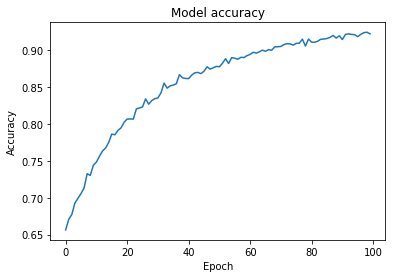

In [27]:
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()